# Minimal Viable Product - Garbage Classifier
Parameters to change for garbage classification:
+ For demo_214 and demo_64, add shortcut to your drive
+ Change path to "drive/MyDrive/demo_214"
+ change modeltype to 'xception' or 'vgg'
+ change imsize to (64,64) or (214,214)

# Convolutional nets
The purpose of this assignment is to help the student get started with convolutional image recogition models for the course project. This assignment will explore how convolutional nets work in depth.

Northwestern MSiA 432 Deep learning 
    Assignment #2 starter code
    
    This code demonstrates the use of transfer learning to speed up
    the training process for a convolutional neural network.
    
    Notes:
        - Heatmaps may appear black in the first few epochs. Wait until accuracy improves.
        - The native image size is 224x224 for VGG, resize/crop your images to match
        - Filter visualization is slow, change vizfilt_timeout for more speed or accuracy
        - Be sure to rename/delete the basepath when changing model parameters, e.g. layers or random labels

In [1]:
# GPU memory fix

import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [2]:
# Show devices
from tensorflow.python.client import device_lib
local_device_protos = device_lib.list_local_devices()
print([x.name for x in local_device_protos])

['/device:CPU:0', '/device:GPU:0']


In [3]:
# Obligatory imports
import os, time, numpy as np, imageio, random, pandas as pd, socket, warnings
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE" # Workaround for Mac

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
# Set project configuration
basepath      = "drive/MyDrive/demo_64" # change MyDrive to Shareddrives
imsize        = (64, 64) # n x n square images, VGG default is 224x224. Remember to change this.
tsize         = imsize + (3,)
trainfolder   = os.path.join(basepath,"train")
testfolder    = os.path.join(basepath,"test")

In [6]:
# Model settings    
vggblocks     = 4        # Number of VGG blocks to create, 0-5 blocks
xferlearning  = 2       # Enable transfer learning up to layer n (max 12, -1 = off)
freeze_conv   = False    # Freeze convolutional layers
fclayersize   = 64      # Size of fully connected (FC) layers
fclayers      = 3        # Number of FC layers
fcdropout     = 0.2      # Dropout regularization factor for FC layers
alpha         = 0      # Leaky ReLU alpha
l1_reg        = 0.2      # L1 regularization for FC
l2_reg        = 0.2      # L2 regularization for FC

In [7]:
# Optimizer settings
optimizer = Adam()   
batch_size, nb_epoch = 64, 10000 # Change for early stopping regularization
batchnorm     = True     # Batch normalization
checkpoint    = True     # Checkpoint models to continue training

# Visualization settings
hsv             = False    # Convert images to Hue/Saturation/Value to be more robust to color variations
vizfilt_timeout = 3        # Decrease for speed, increase for better viz. 0 = off.

In [8]:
# Model checkpointing/stats
#modeltype     = 'vgg'      # Use default VGG model
modeltype     = 'xception' # New Xception model, recommended imsize = (64, 64) or larger
modelarch     = '%s%d-fcl%d-fcs%d-%s-%s' % (modeltype, vggblocks, fclayers, fclayersize, 'hsv' if hsv else 'rgb', socket.gethostname())
modelid       = os.path.join(basepath, 'model-%s.h5' % modelarch)     

In [9]:
# VGG net definition starts here. Change the vggblocks to set how many blocks to transfer
def make_vgg():
    from tensorflow.keras.models import Model
    from tensorflow.keras.regularizers import l1_l2
    from tensorflow.keras.layers import Flatten, Dense, Input, Convolution2D, MaxPooling2D, BatchNormalization, Dropout
    from tensorflow.keras.layers import LeakyReLU
    
    img_input = Input(shape=tsize)
    if vggblocks == 0: x = img_input 
    if vggblocks >= 1: # Block 1
        x = LeakyReLU(alpha)(Convolution2D(64, (3, 3), padding='same', name='block1_conv1')(img_input))
        x = LeakyReLU(alpha)(Convolution2D(64, (3, 3), padding='same', name='block1_conv2')(x))
        x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
        if batchnorm: x = BatchNormalization()(x)
    if vggblocks >= 2: # Block 2
        x = LeakyReLU(alpha)(Convolution2D(128, (3, 3), padding='same', name='block2_conv1')(x))
        x = LeakyReLU(alpha)(Convolution2D(128, (3, 3), padding='same', name='block2_conv2')(x))
        x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
        if batchnorm: x = BatchNormalization()(x)
    if vggblocks >= 3: # Block 3
        x = LeakyReLU(alpha)(Convolution2D(256, (3, 3), padding='same', name='block3_conv1')(x))
        x = LeakyReLU(alpha)(Convolution2D(256, (3, 3), padding='same', name='block3_conv2')(x))
        x = LeakyReLU(alpha)(Convolution2D(256, (3, 3), padding='same', name='block3_conv3')(x))
        x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
        if batchnorm: x = BatchNormalization()(x)
    if vggblocks >= 4: # Block 4
        x = LeakyReLU(alpha)(Convolution2D(512, (3, 3), padding='same', name='block4_conv1')(x))
        x = LeakyReLU(alpha)(Convolution2D(512, (3, 3), padding='same', name='block4_conv2')(x))
        x = LeakyReLU(alpha)(Convolution2D(512, (3, 3), padding='same', name='block4_conv3')(x))
        x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)
        if batchnorm: x = BatchNormalization()(x)
    if vggblocks >= 5: # Block 5
        x = LeakyReLU(alpha)(Convolution2D(512, (3, 3), padding='same', name='block5_conv1')(x))
        x = LeakyReLU(alpha)(Convolution2D(512, (3, 3), padding='same', name='block5_conv2')(x))
        x = LeakyReLU(alpha)(Convolution2D(512, (3, 3), padding='same', name='block5_conv3')(x))
        x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
        if batchnorm: x = BatchNormalization()(x)
        
    x = Flatten(name='flatten')(x)
    for i in range(fclayers): 
        x = LeakyReLU(alpha)(Dense(fclayersize, kernel_regularizer=l1_l2(l1_reg, l2_reg))(x))
        if fcdropout > 0:
            x = Dropout(fcdropout)(x)
    x = Dense(len(obj_classes), activation='softmax', name='predictions')(x)
    
    inputs = img_input
    model = Model(inputs, x, name='vgg16')
    
    # VGG Transfer weights
    from tensorflow.keras.applications import vgg16
    from tensorflow.keras.layers import Conv2D
    vgg16model = vgg16.VGG16(include_top=False)
    modelconv = [l for l in model.layers if type(l) == Conv2D]
    vgg16conv = [l for l in vgg16model.layers if type(l) == Conv2D]
    
    for i, l in enumerate(modelconv):
        if i > xferlearning: continue # Transfer only first n layers
        print('**** Transferring layer %d: %s from VGG ****' % (i, l))
        weights = vgg16conv[i].get_weights()
        modelconv[i].set_weights(weights)
        if freeze_conv: l.trainable = False

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    return model, img_input

In [10]:
# Load data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,                         # rescale data
    shear_range=0.2,
    zoom_range=0.2,    
    rotation_range=180,                       # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.3,                  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.3,                 # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,                   # randomly flip images
    vertical_flip=True)                    # randomly flip images

train_generator = datagen.flow_from_directory(
        trainfolder,
        target_size=imsize,
        batch_size=batch_size)

test_generator = datagen.flow_from_directory(
        testfolder,
        target_size=imsize,
        batch_size=-1)

X_test, Y_test = test_generator.next()

obj_classes = sorted(train_generator.class_indices.keys())
class_to_idx = dict([(y, x) for (x,y) in enumerate(obj_classes)])
img_rows, img_cols, img_channels = X_test.shape[1:]

Found 1841 images belonging to 5 classes.
Found 549 images belonging to 5 classes.


In [11]:
#%% Xception definition
def make_xception():
    import tensorflow
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
    from tensorflow.keras.regularizers import l1
    xmodel = tensorflow.keras.applications.Xception(include_top=False)
    x = xmodel.output
    #for layer in xmodel.layers: layer.trainable = False
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, kernel_regularizer=l1(1e-7))(x)
    predictions = Dense(len(obj_classes), activation='softmax')(x)
    
    model = Model(inputs=xmodel.input, outputs=predictions)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam())
    model.summary()
    return model, xmodel.input

In [12]:
# modeltype = 'xception'

if modeltype == 'vgg':
    model, img_input = make_vgg()    
elif modeltype == 'xception':
    model, img_input = make_xception()

Instructions for updating:
Colocations handled automatically by placer.
83689472/83683744 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0  

In [13]:
#%% Visualization code
def viz_losses(stats): 
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
    epoch = len(stats)
    convlayers = len([l.name for l in model.layers if 'conv' in l.name])
    blocks     = len(set([l.name.split('_')[0] for l in model.layers if 'block' in l.name]))
    dense      = len([l.name for l in model.layers if 'dense' in l.name])
    fcsize     = model.layers[-1].input_shape[1]
    fig.suptitle("Training %s blocks=%d, conv=%d, dense=%d, fcsize=%d, epoch=%d" % (modeltype, blocks, convlayers, dense, fcsize, epoch))
    ax1.plot(stats['Train loss'].values, label='Train loss', color='blue')
    ax1.plot(stats['Test loss'].values, label='Test loss', color='green')
    ax1.set_yscale('log')
    ax2.plot(stats['Accuracy'].values, label='Test accuracies', color='red')
    ax2.plot(stats['Train accuracy'].values, label='Train accuracies', color='blue')
    ax2.axhline(1.0/len(obj_classes), linestyle='dashed', color='gray')
    dataset = pd.Series(train_generator.classes)
    chance = dataset.value_counts().max() / dataset.value_counts().sum()
    ax2.text(0, chance, 'Chance')
    ax2.axhline(np.max(stats['Accuracy']), linestyle='dashed', color='red')
    ax2.text(0, np.max(stats['Accuracy']), 'Best')    
    ax2.set_ylim([0, 1])
    ax2.set_title('Accuracy: %0.2f%%' % (100.0*stats['Accuracy'].values[-1]))     
    ax1.legend(), ax2.legend()
    plt.savefig(os.path.join(basepath, 'loss-%s.png' % modelarch))
    plt.show()    
    plt.close()

In [14]:
#%% Explanations
import skimage.exposure, skimage.filters
from skimage.color import gray2rgb
from tensorflow.keras import backend as K

def hide_axes(ax): ax.set_xticks([]), ax.set_yticks([])
class Heatmap:
    def __init__(self, model, obj_classes):
        self.obj_classes = obj_classes
        self.nclasses    = len(obj_classes)
        self.model       = model
    
    def make_masks(self, im, n=8, maskval=0.1):
        masks = []
        xwidth, ywidth = int(np.ceil(im.shape[0]/n)), int(np.ceil(im.shape[1]/n))
        for i in range(n):
            for j in range(n):
                mask = np.ones(im.shape[:2])
                mask[(i*xwidth):((i+1)*xwidth), (j*ywidth):((j+1)*ywidth)] = maskval
                mask = skimage.filters.gaussian(mask, 1) # Change this for local mask smoothing
                masks.append(mask)
        return np.array(masks)

    def get_slice_masks(self, im, n_segments=16, blur=0.03):
        from skimage.segmentation import slic
        segments = slic(im, n_segments=n_segments, sigma=5)
        masks = []
        # loop over the unique segment values
        for (i, segVal) in enumerate(np.unique(segments)):
            # construct a mask for the segment
            mask = np.zeros(im.shape[:2], dtype="float32")
            mask[segments == segVal] = 1
            mask = skimage.filters.gaussian(mask, im.shape[1]*blur) # Change this for local mask smoothing            
            masks.append(mask)
        return np.array(masks), segments
        
    def explain_prediction_heatmap(self, im, actual):
        import skimage.color
        def hsv_fn(im): return skimage.color.rgb2hsv(im) if hsv else im
        plt.imshow(hsv_fn(im), interpolation='bilinear'), plt.xticks([]), plt.yticks([]), plt.title('Full image'), plt.show(), plt.close()
        masks = np.concatenate([self.make_masks(im, n=i) for i in (9, 7, 5, 3, 2)])
        #masks, segments = self.get_slice_masks(im)        
        masknorm = masks.sum(axis=0)
        heatmaps = np.zeros((self.nclasses,) + im.shape[:2])
        for m in masks:
            prediction = self.model.predict(np.expand_dims(im*gray2rgb(m), 0))
            for c in range(self.nclasses):
                heatmaps[c] += (prediction[0][c]*m)
        for h in heatmaps: h = h / masknorm
        fig, axes = plt.subplots(2, self.nclasses + 1, figsize=(20, 5))
        #axes[0,0].imshow(hsv(im)), axes[1,0].imshow(mark_boundaries(im, segments))        
        axes[0,0].imshow(hsv_fn(im)), axes[1,0].imshow(im)        
        
        axes[0,0].set_title(actual)
        axes[1,0].set_title('HSV' if hsv else 'RGB')        
        hide_axes(axes[0,0]), hide_axes(axes[1,0])       
        predictions = np.sum(heatmaps, axis=(1,2,))
        predictions /= predictions.max()
        for n, i in enumerate(np.argsort(predictions)[::-1][:self.nclasses]):
            h = ((255 * heatmaps[i])/heatmaps[i].max()).astype('uint16')
            try:
                h = skimage.exposure.equalize_adapthist(h)
            except IndexError: pass
            h = skimage.filters.gaussian(h, 1) # Change this for global mask smoothing
            axes[0, n+1].imshow(gray2rgb(h))
            axes[1, n+1].imshow(gray2rgb(h) * hsv_fn(im) * (0.5 + 0.5*predictions[i]))  
            hide_axes(axes[0, n+1]), hide_axes(axes[1, n+1])        
            axes[0, n+1].set_title(self.obj_classes[i] + ': %0.1f%%' % (100*predictions[i]/predictions.sum()))
        fig.tight_layout()
        plt.savefig(os.path.join(basepath, 'heatmap-%05d.png') % np.random.randint(0, 99999))
        plt.show()
        plt.close()
        return heatmaps

In [15]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x = x*0.1 + 0.5
    x = np.clip(x, 0, 1) * 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def viz_filter_max(layer_name, filter_index=0, max_steps=9999, timeout=3):
    from tensorflow.keras.utils import Progbar            
    layer_output = layer_dict[layer_name].output
    loss = K.mean(layer_output[:, :, :, filter_index])

    grads = K.gradients(loss, img_input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([img_input], [loss, grads])
    step = 1e-0
    input_img_data = np.random.random((1, img_rows, img_cols, 3))
    input_img_data = (input_img_data - 0.5) * 20 + 128

    tm = time.time()

    for i in range(max_steps):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        if time.time() - tm > timeout:
            plt.text(0.1, 0.1, "Filter viz timeout: %d" % timeout, color='red')
            break
    img = input_img_data[0]
    img = deprocess_image(img)
    fig = plt.imshow(img)    
    hide_axes(fig.axes)
    return layer_output
    
def viz_filters(model, img_input, img_rows, img_cols, nbfilters=3, timeout=60):
    tm = time.time()
    print("Visualizing filters (CTRL-C to cancel)")
    try:         
        for layer_name in sorted(layer_dict.keys()):
            if time.time() - tm > timeout:
                print("Filter visualization timed out: %d. Change timeout in viz_filters()." % timeout)
                break
            if not hasattr(layer_dict[layer_name], 'filters'): continue
            nfilters = layer_dict[layer_name].filters
            fig, ax = plt.subplots(1, nbfilters, figsize=(8, 4))
            fig.suptitle("Layer %s has %d filters" % (layer_name, nfilters))            
            for j in range(nbfilters):
                plt.subplot(1, nbfilters, j + 1)
                viz_filter_max(layer_name, random.randint(0, nfilters-1), timeout=vizfilt_timeout)
            fig.tight_layout()    
            plt.savefig(os.path.join(basepath, 'filters-%s-%s.png' % (modelarch, layer_name))) 
            plt.show(), plt.close()
    except KeyboardInterrupt: return

In [16]:
def test_prediction(im, y):
    pred = model.predict(np.expand_dims(im, 0))
    cls = np.argmax(y)
    heatmap = Heatmap(model, obj_classes)                
    heatmap.explain_prediction_heatmap(im, obj_classes[cls])
    
    print("Actual: %s(%d)" % (obj_classes[cls], cls))
    for cls in list(reversed(np.argsort(pred)[0]))[:5]:
        conf = float(pred[0, cls])/pred.sum()
        print("    predicted: %010s(%d), confidence=%0.2f [%-10s]" % (obj_classes[cls], cls, conf, "*" * int(10*conf)))
    return pred

def confusion_matrix(model, X, T, accpct):
    import seaborn
    from sklearn.metrics import classification_report, confusion_matrix
    Y_pred = model.predict(X)
    y_pred = np.argmax(Y_pred, axis=1)
    y_test = np.argmax(T, axis=1)
    print('Confusion Matrix')
    data = confusion_matrix(y_test, y_pred)
    data = data / data.sum(axis=1)
    #print('Classification Report')
    #print(classification_report(y_test, y_pred, target_names=obj_classes))
    seaborn.set_style("whitegrid", {'axes.grid' : False})
    seaborn.heatmap(data, annot=data*100, fmt='0.0f', cmap='Wistia', xticklabels=obj_classes, yticklabels=obj_classes)
    plt.xlabel('Predicted'), plt.ylabel('Actual'), plt.title('Confusion matrix (ACC %0.2f%%)' % (accpct*100))
    plt.show(), plt.close()

def tsne_viz(model, X, Y, accpct, n=500):
    import sklearn.manifold, matplotlib.cm as cm
    predictions = model.predict(X)    
    colors = iter(cm.rainbow(np.linspace(0, 1, len(obj_classes))))
    X_embedded = sklearn.manifold.TSNE(n_components=2).fit_transform(predictions[:n])
    for d in range(len(obj_classes)):
        xx = X_embedded[Y[:n][:, d] == 1, 0]
        yy = X_embedded[Y[:n][:, d] == 1, 1]
        plt.scatter(xx, yy, c=[next(colors)], label=obj_classes[d])
        t = plt.text(np.median(xx), np.median(yy), obj_classes[d], fontsize=24)
        t.set_bbox({'facecolor': 'white', 'alpha': 0.75})
    plt.title('T-SNE viz - Accuracy: %0.2f%%' % (accpct*100)), plt.legend()

In [17]:
if checkpoint and os.path.exists(modelid): 
    print("**** Loading existing model: %s ****" % modelid)
    try:
        model.load_weights(modelid)
    except ValueError:
        print("Model restore failed. Model topology must match to restore weights. Please delete weight checkpoint model.h5.")
    except OSError:
        print("Model checkpoint corrupted. Please delete.")

# 60 x 60 VGG
### vggblocks: 4
### xferlearning:2 

Confusion Matrix


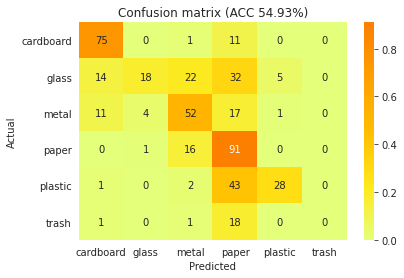

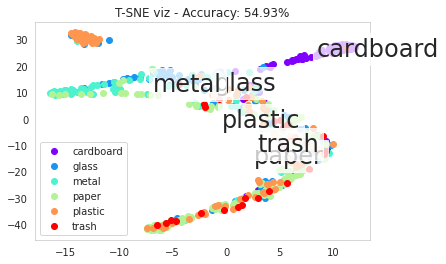

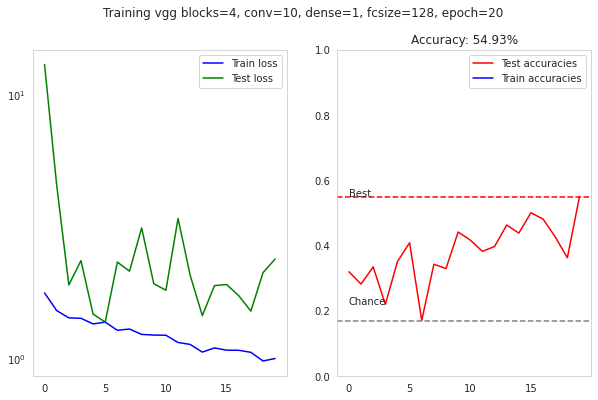

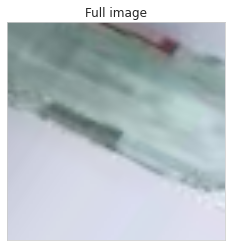

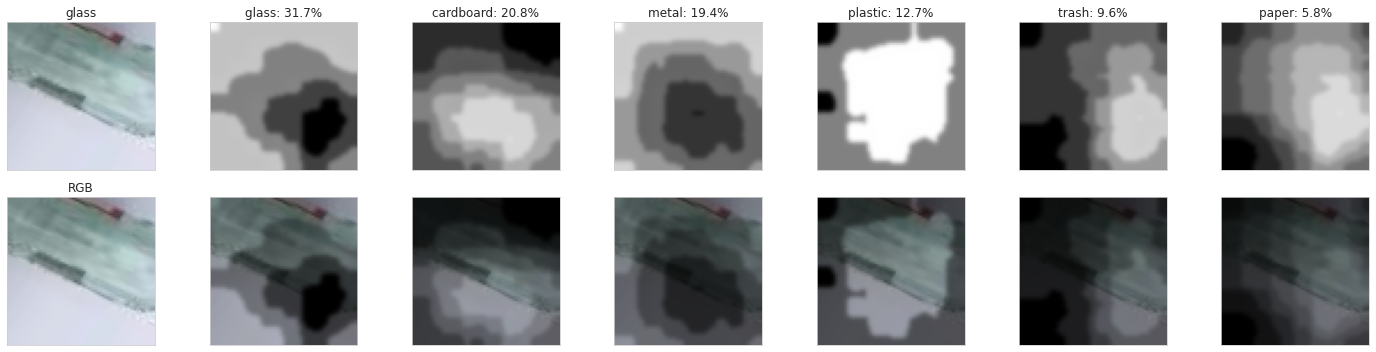

Actual: glass(1)
    predicted:      glass(1), confidence=0.26 [**        ]
    predicted:  cardboard(0), confidence=0.24 [**        ]
    predicted:    plastic(4), confidence=0.15 [*         ]
    predicted:      metal(2), confidence=0.14 [*         ]
    predicted:      trash(5), confidence=0.12 [*         ]
Visualizing filters (CTRL-C to cancel)


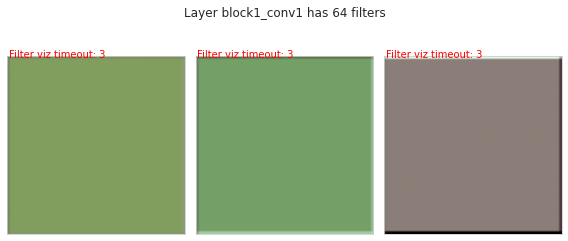

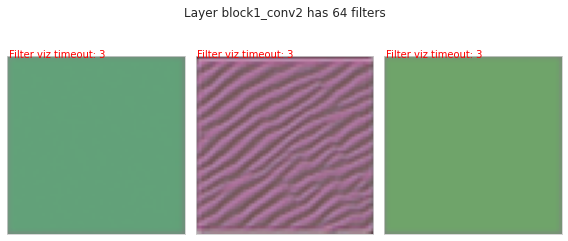

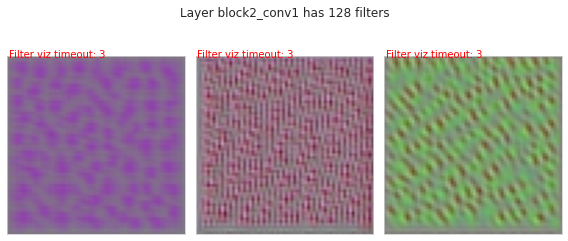

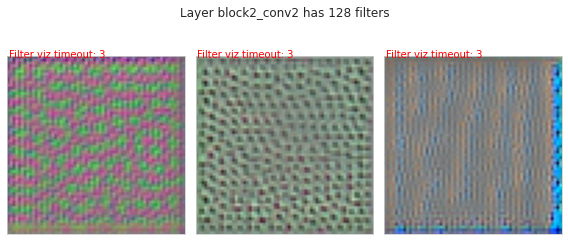

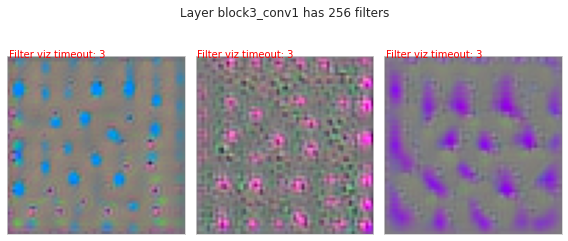

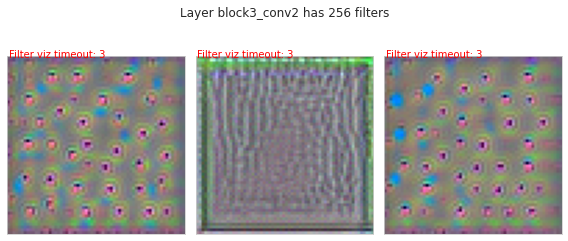

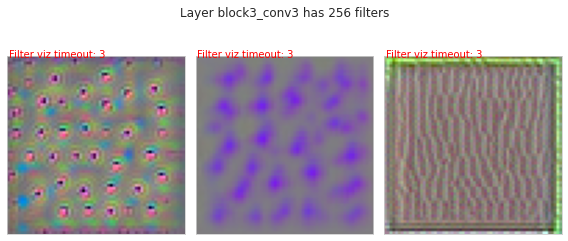

Filter visualization timed out: 60. Change timeout in viz_filters().
Total training time: 12.61 min, epoch: 20
Average time per epoch: 37.84 s
60/60 [==============================] - 84s 1s/step - batch: 29.5000 - size: 31.8000 - loss: 0.9965 - accuracy: 0.6205 - val_loss: 2.3762 - val_accuracy: 0.5493


In [ ]:
#%% Training code
from IPython.display import clear_output

tm = time.time()
trainstats = pd.DataFrame(columns=('Train loss', 'Test loss', 'Accuracy', 'Train accuracy'))

from tensorflow.keras.callbacks import Callback
class VizTraining(Callback):
    def on_epoch_end(self, epoch, logs={}):
        clear_output(wait=True)
        tacc = logs.get('val_accuracy')
        trainstats.loc[len(trainstats)] = (logs.get('loss'), logs.get('val_loss'), tacc, logs.get('acc')) 
        confusion_matrix(model, X_test, Y_test, tacc)
        tsne_viz(model, X_test, Y_test, tacc)        
        viz_losses(trainstats)
        t_ind = random.randint(0, len(X_test) - 1)        
        test_prediction(X_test[t_ind], Y_test[t_ind])    
        if modeltype == 'vgg' and vizfilt_timeout > 0 and np.random.randint(0, 3) == 0: 
            viz_filters(model, img_input, img_rows, img_cols)
        if checkpoint: model.save(modelid, overwrite=True)
        print("Total training time: %0.2f min, epoch: %d" % ((time.time() - tm)/60.0, len(trainstats))) 
        print("Average time per epoch: %0.2f s" % ((time.time() - tm)/len(trainstats)))

loss = model.fit(
    train_generator,
    steps_per_epoch=int(len(train_generator.filenames)/batch_size),
    validation_data=(X_test, Y_test),
    validation_steps=1,
    verbose=1, epochs=20,
    use_multiprocessing=True,
    workers=4,
    callbacks=[VizTraining()]
)

# 60 x 60 Xception

Confusion Matrix


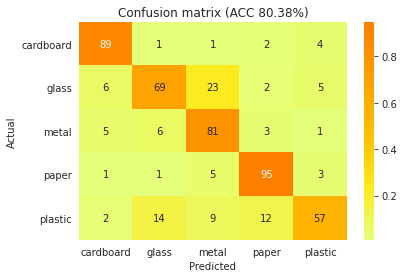

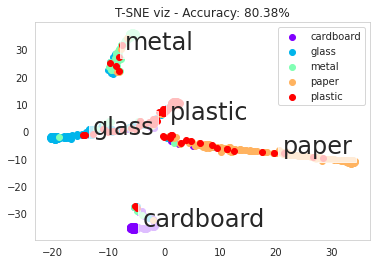

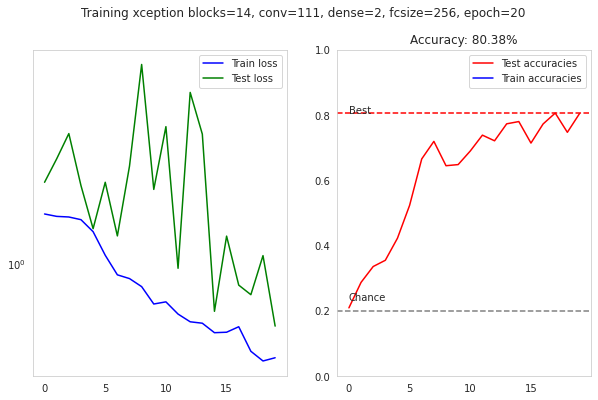

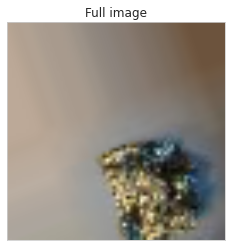

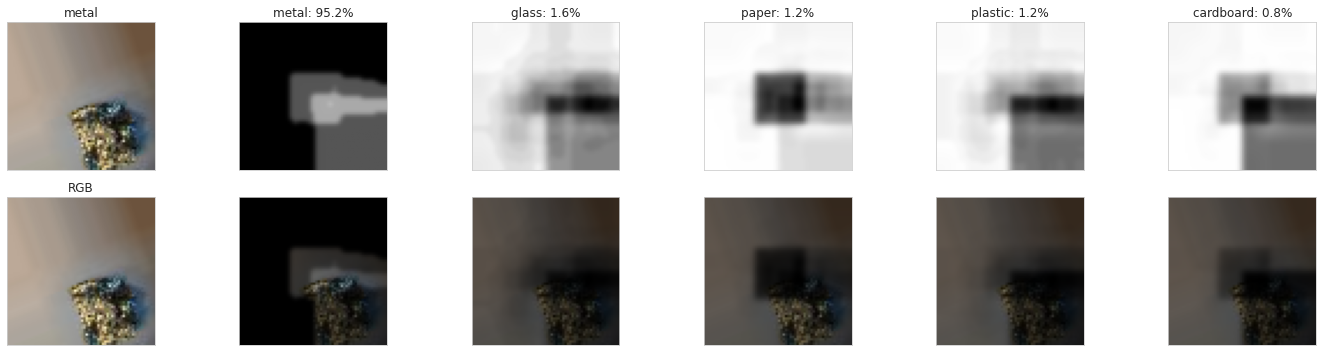

Actual: metal(2)
    predicted:      metal(2), confidence=0.99 [********* ]
    predicted:      glass(1), confidence=0.01 [          ]
    predicted:    plastic(4), confidence=0.00 [          ]
    predicted:      paper(3), confidence=0.00 [          ]
    predicted:  cardboard(0), confidence=0.00 [          ]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Total training time: 9.06 min, epoch: 20
Average time per epoch: 27.18 s
28/28 [==============================] - 21s 763ms/step - batch: 13.5000 - size: 63.4643 - loss: 0.3891 - accuracy: 0.8751 - val_loss: 0.5344 - val_accuracy: 0.8038


In [18]:
#%% Training code
from IPython.display import clear_output

tm = time.time()
trainstats = pd.DataFrame(columns=('Train loss', 'Test loss', 'Accuracy', 'Train accuracy'))

from tensorflow.keras.callbacks import Callback
class VizTraining(Callback):
    def on_epoch_end(self, epoch, logs={}):
        clear_output(wait=True)
        tacc = logs.get('val_accuracy')
        trainstats.loc[len(trainstats)] = (logs.get('loss'), logs.get('val_loss'), tacc, logs.get('acc')) 
        confusion_matrix(model, X_test, Y_test, tacc)
        tsne_viz(model, X_test, Y_test, tacc)        
        viz_losses(trainstats)
        t_ind = random.randint(0, len(X_test) - 1)        
        test_prediction(X_test[t_ind], Y_test[t_ind])    
        if modeltype == 'vgg' and vizfilt_timeout > 0 and np.random.randint(0, 3) == 0: 
            viz_filters(model, img_input, img_rows, img_cols)
        if checkpoint: model.save(modelid, overwrite=True)
        print("Total training time: %0.2f min, epoch: %d" % ((time.time() - tm)/60.0, len(trainstats))) 
        print("Average time per epoch: %0.2f s" % ((time.time() - tm)/len(trainstats)))

loss = model.fit(
    train_generator,
    steps_per_epoch=int(len(train_generator.filenames)/batch_size),
    validation_data=(X_test, Y_test),
    validation_steps=1,
    verbose=1, epochs=20,
    use_multiprocessing=True,
    workers=4,
    callbacks=[VizTraining()]
)

# 214 x 214 VGG

In [ ]:
#%% Training code
from IPython.display import clear_output

tm = time.time()
trainstats = pd.DataFrame(columns=('Train loss', 'Test loss', 'Accuracy', 'Train accuracy'))

from tensorflow.keras.callbacks import Callback
class VizTraining(Callback):
    def on_epoch_end(self, epoch, logs={}):
        clear_output(wait=True)
        tacc = logs.get('val_accuracy')
        trainstats.loc[len(trainstats)] = (logs.get('loss'), logs.get('val_loss'), tacc, logs.get('acc')) 
        confusion_matrix(model, X_test, Y_test, tacc)
        tsne_viz(model, X_test, Y_test, tacc)        
        viz_losses(trainstats)
        t_ind = random.randint(0, len(X_test) - 1)        
        test_prediction(X_test[t_ind], Y_test[t_ind])    
        if modeltype == 'vgg' and vizfilt_timeout > 0 and np.random.randint(0, 3) == 0: 
            viz_filters(model, img_input, img_rows, img_cols)
        if checkpoint: model.save(modelid, overwrite=True)
        print("Total training time: %0.2f min, epoch: %d" % ((time.time() - tm)/60.0, len(trainstats))) 
        print("Average time per epoch: %0.2f s" % ((time.time() - tm)/len(trainstats)))

loss = model.fit(
    train_generator,
    steps_per_epoch=int(len(train_generator.filenames)/batch_size),
    validation_data=(X_test, Y_test),
    validation_steps=1,
    verbose=1, epochs=20,
    use_multiprocessing=True,
    workers=4,
    callbacks=[VizTraining()]
)

# 214 x 214 Xception

Confusion Matrix


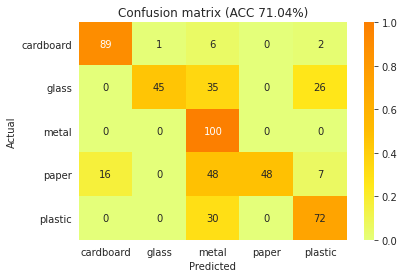

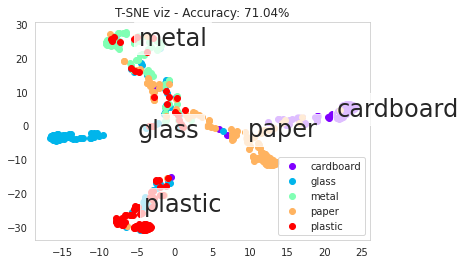

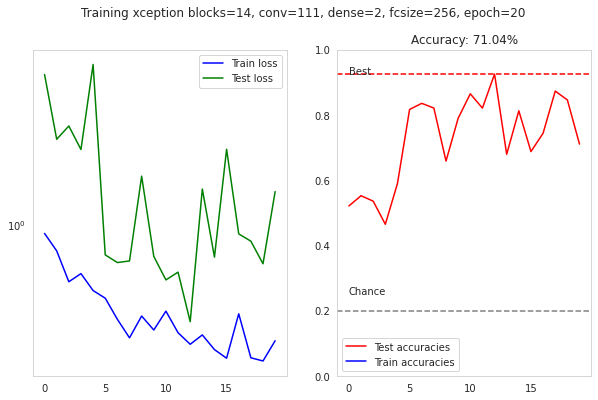

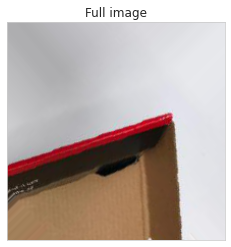

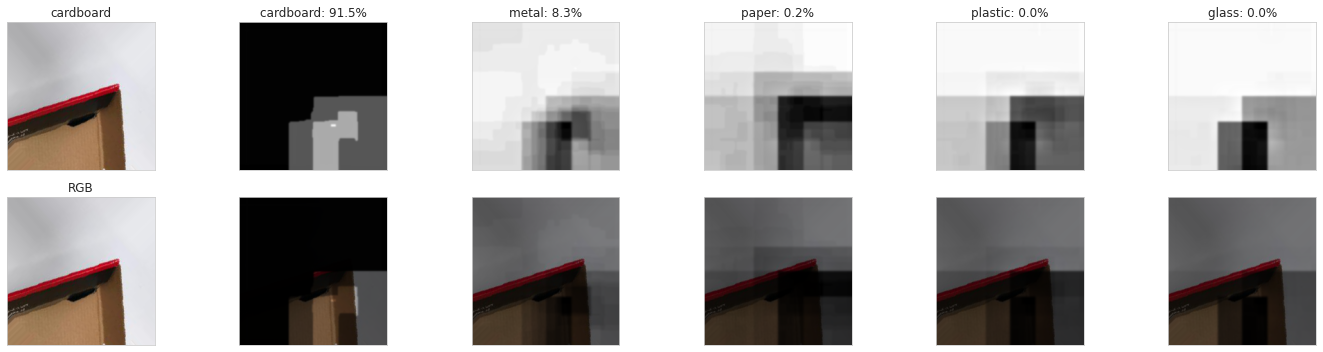

Actual: cardboard(0)
    predicted:  cardboard(0), confidence=0.90 [********  ]
    predicted:      metal(2), confidence=0.10 [          ]
    predicted:      paper(3), confidence=0.00 [          ]
    predicted:    plastic(4), confidence=0.00 [          ]
    predicted:      glass(1), confidence=0.00 [          ]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Total training time: 20.02 min, epoch: 20
Average time per epoch: 60.06 s
60/60 [==============================] - 54s 908ms/step - batch: 29.5000 - size: 31.5667 - loss: 0.2855 - accuracy: 0.9092 - val_loss: 1.4469 - val_accuracy: 0.7104


In [ ]:
#%% Training code
from IPython.display import clear_output

tm = time.time()
trainstats = pd.DataFrame(columns=('Train loss', 'Test loss', 'Accuracy', 'Train accuracy'))

from tensorflow.keras.callbacks import Callback
class VizTraining(Callback):
    def on_epoch_end(self, epoch, logs={}):
        clear_output(wait=True)
        tacc = logs.get('val_accuracy')
        trainstats.loc[len(trainstats)] = (logs.get('loss'), logs.get('val_loss'), tacc, logs.get('acc')) 
        confusion_matrix(model, X_test, Y_test, tacc)
        tsne_viz(model, X_test, Y_test, tacc)        
        viz_losses(trainstats)
        t_ind = random.randint(0, len(X_test) - 1)        
        test_prediction(X_test[t_ind], Y_test[t_ind])    
        if modeltype == 'vgg' and vizfilt_timeout > 0 and np.random.randint(0, 3) == 0: 
            viz_filters(model, img_input, img_rows, img_cols)
        if checkpoint: model.save(modelid, overwrite=True)
        print("Total training time: %0.2f min, epoch: %d" % ((time.time() - tm)/60.0, len(trainstats))) 
        print("Average time per epoch: %0.2f s" % ((time.time() - tm)/len(trainstats)))

loss = model.fit(
    train_generator,
    steps_per_epoch=int(len(train_generator.filenames)/batch_size),
    validation_data=(X_test, Y_test),
    validation_steps=1,
    verbose=1, epochs=20,
    use_multiprocessing=True,
    workers=4,
    callbacks=[VizTraining()]
)

# Image Transform - full rotation, shift 30%, flip

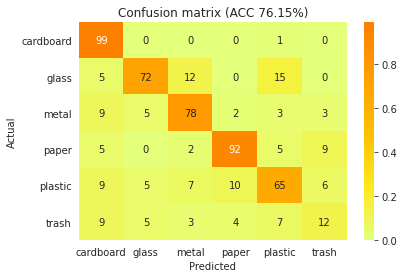

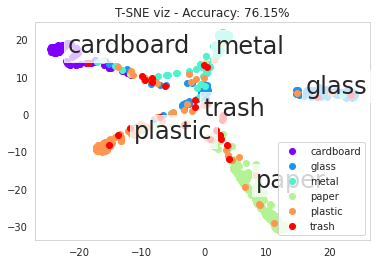

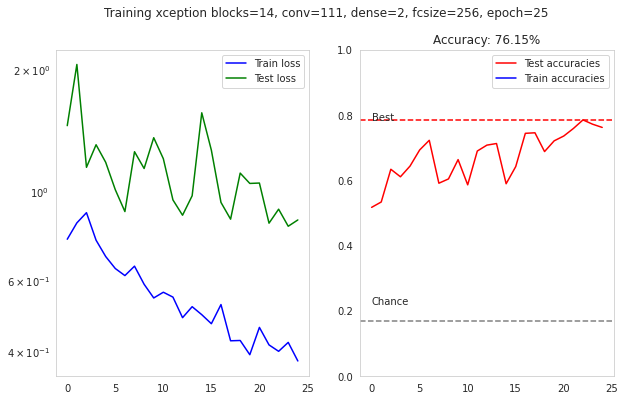

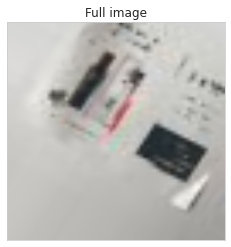

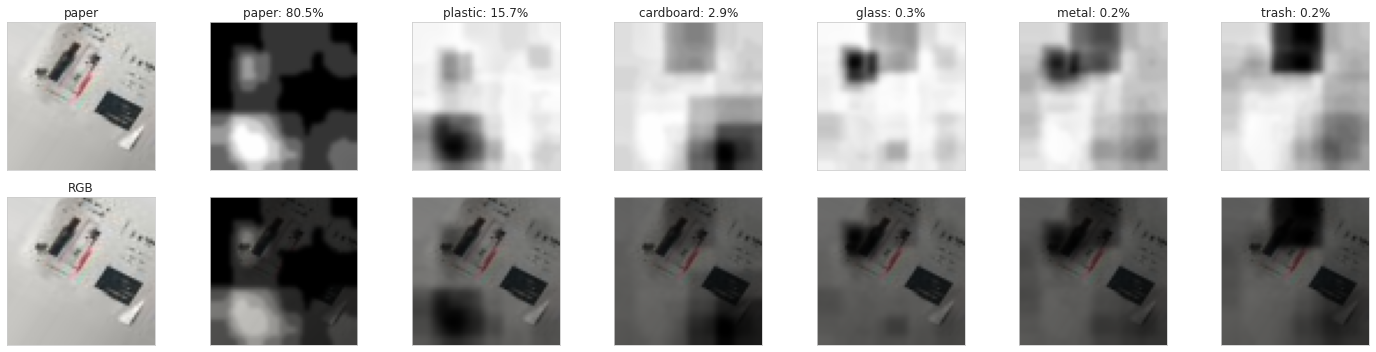

Actual: paper(3)
    predicted:      paper(3), confidence=0.97 [********* ]
    predicted:  cardboard(0), confidence=0.02 [          ]
    predicted:    plastic(4), confidence=0.01 [          ]
    predicted:      trash(5), confidence=0.00 [          ]
    predicted:      metal(2), confidence=0.00 [          ]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Total training time: 10.20 min, epoch: 25
Average time per epoch: 24.47 s
60/60 [==============================] - 24s 405ms/step - batch: 29.5000 - size: 31.9000 - loss: 0.3775 - accuracy: 0.8715 - val_loss: 0.8469 - val_accuracy: 0.7615


In [ ]:
#%% Training code
from IPython.display import clear_output

tm = time.time()
trainstats = pd.DataFrame(columns=('Train loss', 'Test loss', 'Accuracy', 'Train accuracy'))

from tensorflow.keras.callbacks import Callback
class VizTraining(Callback):
    def on_epoch_end(self, epoch, logs={}):
        clear_output(wait=True)
        tacc = logs.get('val_accuracy')
        trainstats.loc[len(trainstats)] = (logs.get('loss'), logs.get('val_loss'), tacc, logs.get('acc')) 
        confusion_matrix(model, X_test, Y_test, tacc)
        tsne_viz(model, X_test, Y_test, tacc)        
        viz_losses(trainstats)
        t_ind = random.randint(0, len(X_test) - 1)        
        test_prediction(X_test[t_ind], Y_test[t_ind])    
        if modeltype == 'vgg' and vizfilt_timeout > 0 and np.random.randint(0, 3) == 0: 
            viz_filters(model, img_input, img_rows, img_cols)
        if checkpoint: model.save(modelid, overwrite=True)
        print("Total training time: %0.2f min, epoch: %d" % ((time.time() - tm)/60.0, len(trainstats))) 
        print("Average time per epoch: %0.2f s" % ((time.time() - tm)/len(trainstats)))

loss = model.fit(
    train_generator,
    steps_per_epoch=int(len(train_generator.filenames)/batch_size),
    validation_data=(X_test, Y_test),
    validation_steps=1,
    verbose=1, epochs=25,
    use_multiprocessing=True,
    workers=4,
    callbacks=[VizTraining()]
)